In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit



import warnings
warnings.filterwarnings('ignore')

In [ ]:
end = '2019-12-31'
start = '1999-01-02'

trainingData = yf.download('AAPL', start=start, end=end)
trainingData.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-04,0.376116,0.377232,0.357143,0.368304,0.311806,952884800
1999-01-05,0.374442,0.392299,0.370536,0.386719,0.327396,1410113600
1999-01-06,0.393973,0.393973,0.366071,0.372768,0.315585,1348569600
1999-01-07,0.377232,0.402344,0.376116,0.401786,0.340152,1429019200
1999-01-08,0.415737,0.418527,0.392857,0.401786,0.340152,678832000


In [ ]:
#Downloading of data from Yahoo Finance which will be used for model testing
end = '2024-03-28'
start = '2020-01-02'

testingData = yf.download('AAPL', start=start, end=end)
testingData.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059433,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349144,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925636,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582664,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750259,132079200


In [ ]:
trainprice = trainingData['Adj Close']
trainData = trainprice.values

testprice = testingData['Adj Close']
testData = testprice.values

In [ ]:
trainData


array([ 0.31180596,  0.32739615,  0.31558526, ..., 70.51990509,
       70.4931488 , 70.91153717])

Plotting of High vs Low

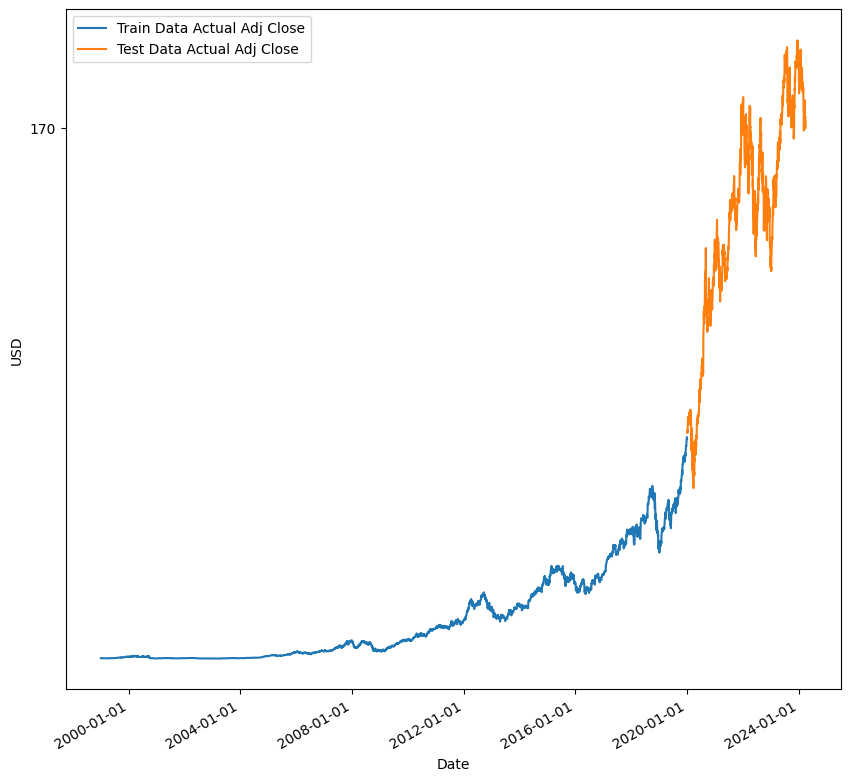

In [ ]:
plt.figure(figsize=(10,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().yaxis.set_major_locator(mdates.DayLocator(interval=200))

plt.plot(trainingData.index, trainingData['Adj Close'], label='Train Data Actual Adj Close')
plt.plot(testingData.index, testingData['Adj Close'], label='Test Data Actual Adj Close')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
trainDataScaled = sc.fit_transform(trainData.reshape(-1, 1))
testDataScaled = sc.fit_transform(testData.reshape(-1, 1))

In [ ]:
n_steps = 20

xTrain, yTrain = [], []

for i in range(n_steps, len(trainDataScaled)):
    xTrain.append(trainDataScaled[i-n_steps:i, 0])
    yTrain.append(trainDataScaled[i, 0])

xTrain, yTrain = np.array(xTrain), np.array(yTrain)
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))


In [ ]:
#LSTM Model

model = Sequential()

#Layer 1
model.add(LSTM(units=180,return_sequences=True,input_shape=(xTrain.shape[1], 1)))
model.add(Dropout(0.2))
#Layer 2
model.add(LSTM(units=180,return_sequences=True))
model.add(Dropout(0.2))
# #Layer 3
model.add(LSTM(units=180,return_sequences=True))
model.add(Dropout(0.2))
# #Layer 4
model.add(LSTM(units=180,return_sequences=False))
model.add(Dropout(0.2))
#Layer 5
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
model.summary()

#Early stopping parameters to stop unnecessary training
earlyStopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=15,
    mode='min',
    min_delta = 0.00001
)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 20, 180)           131040    
                                                                 
 dropout_16 (Dropout)        (None, 20, 180)           0         
                                                                 
 lstm_17 (LSTM)              (None, 20, 180)           259920    
                                                                 
 dropout_17 (Dropout)        (None, 20, 180)           0         
                                                                 
 lstm_18 (LSTM)              (None, 20, 180)           259920    
                                                                 
 dropout_18 (Dropout)        (None, 20, 180)           0         
                                                                 
 lstm_19 (LSTM)              (None, 180)              

In [ ]:
#Method to plot the training metric vs validation metric
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [ ]:
#Evaluation of model to confirm if parameters set above are valid
eval = model.evaluate(xTrain, yTrain)

165/165 [==============================] - 13s 69ms/step - loss: 0.0801 - root_mean_squared_error: 0.2830 - mean_absolute_error: 0.1815


In [ ]:
len(xTrain)

5262

Epoch 1/100
31/31 [==============================] - 26s 552ms/step - loss: 0.0022 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0287 - val_loss: 0.1145 - val_root_mean_squared_error: 0.3384 - val_mean_absolute_error: 0.3104
Epoch 2/100
31/31 [==============================] - 18s 580ms/step - loss: 0.0047 - root_mean_squared_error: 0.0685 - mean_absolute_error: 0.0489 - val_loss: 0.1858 - val_root_mean_squared_error: 0.4310 - val_mean_absolute_error: 0.3996
Epoch 3/100
31/31 [==============================] - 19s 605ms/step - loss: 0.0043 - root_mean_squared_error: 0.0653 - mean_absolute_error: 0.0509 - val_loss: 0.0247 - val_root_mean_squared_error: 0.1571 - val_mean_absolute_error: 0.1146
Epoch 4/100
31/31 [==============================] - 16s 533ms/step - loss: 0.0076 - root_mean_squared_error: 0.0870 - mean_absolute_error: 0.0607 - val_loss: 0.0420 - val_root_mean_squared_error: 0.2050 - val_mean_absolute_error: 0.1498
Epoch 5/100
31/31 [=============================

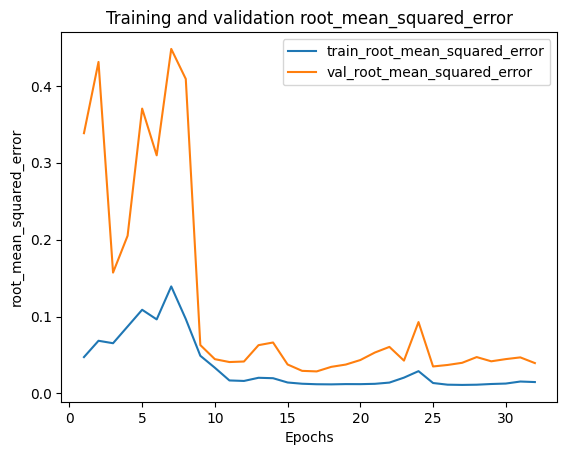

In [ ]:
log = model.fit(
    xTrain,
    yTrain,
    epochs=100,
    batch_size=128,
    validation_split = 0.25,
    verbose=1,
    callbacks=[earlyStopping],
    shuffle=False)
plot_metric(log, 'root_mean_squared_error')

In [ ]:
n_steps = 20

xTest = []
yTest = []

for i in range(n_steps, len(testDataScaled)):
    xTest.append(testDataScaled[i-n_steps:i, 0])
    yTest.append(testDataScaled[i, 0])

xTest, yTest = np.array(xTest), np.array(yTest)
xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))



In [ ]:
predictions = model.predict(xTest) #Prediction on Data using trained model
output = sc.inverse_transform(predictions)
rmse = np.sqrt(mean_squared_error(predictions, yTest)) #Calculating of RMSE
rmse

33/33 [==============================] - 3s 59ms/step


0.05932294115674232

In [ ]:
eval = model.evaluate(xTest, yTest) #Calculating of additional metrics (Loss, RMSE, MAE)

33/33 [==============================] - 2s 60ms/step - loss: 0.0035 - root_mean_squared_error: 0.0593 - mean_absolute_error: 0.0463


In [ ]:
df1 = pd.DataFrame(testingData['Adj Close']).astype(float)
df1 = df1.iloc[:-20]
df1 = df1.reset_index(drop=False)

df2 = pd.DataFrame(output, columns = ['Pred Adj Close']).astype(float)


In [ ]:
df2

,Pred Adj Close
0,76.974045
1,77.250793
2,77.639824
3,78.033897
4,78.371796
...,...
1041,182.470749
1042,182.737915
1043,182.805542
1044,182.461395


In [ ]:
df = df1.join(df2)
df = df.set_index('Date')

In [ ]:
df

,Adj Close,Pred Adj Close
Date,,
2020-01-02,73.059433,76.974045
2020-01-03,72.349144,77.250793
2020-01-06,72.925636,77.639824
2020-01-07,72.582664,78.033897
2020-01-08,73.750259,78.371796
...,...,...
2024-02-22,184.369995,182.470749
2024-02-23,182.520004,182.737915
2024-02-26,181.160004,182.805542


Results

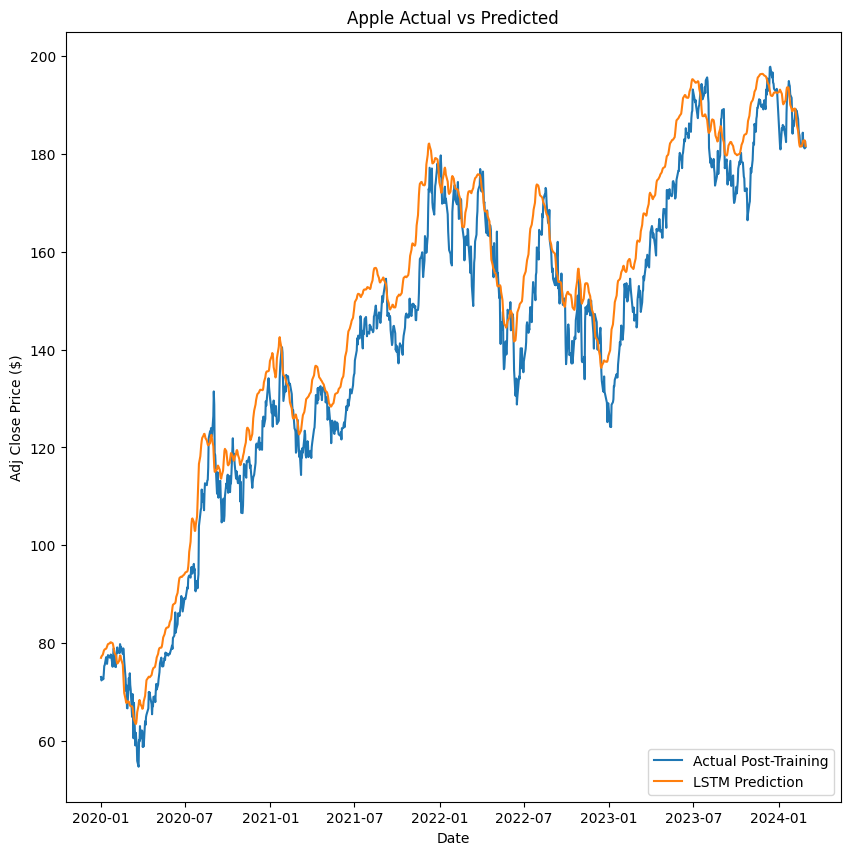

In [ ]:

real = df['Adj Close']
pred = df['Pred Adj Close']
plt.figure(figsize=(10,10))
plt.title('Apple Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Adj Close Price ($)')
plt.plot(real)
plt.plot(pred)
plt.legend(['Actual Post-Training','LSTM Prediction'], loc='lower right')
plt.xticks()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

last_sequence = testDataScaled[-n_steps:].reshape(1, n_steps, 1)
future_predictions = []
for _ in range(30):
    next_day_pred = model.predict(last_sequence)
    future_predictions.append(next_day_pred.flatten()[0])
    last_sequence = np.append(last_sequence[:, 1:, :], np.expand_dims(next_day_pred, axis=1), axis=1)

future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = sc.inverse_transform(future_predictions)

last_date = testingData.index.max()
# Using bdate_range to ensure only business days are included
predicted_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='B')

predicted_df = pd.DataFrame(future_predictions, index=predicted_dates, columns=['Predicted Adj Close'])
print(predicted_df)

1/1 [==============================] - 0s 37ms/step
            Predicted Adj Close
2024-03-28           180.564621
2024-03-29           179.521927
2024-04-01           178.797928
2024-04-02           178.632538
2024-04-03           178.990265
2024-04-04           179.648834
2024-04-05           180.510391
2024-04-08           181.438019
2024-04-09           182.346970
2024-04-10           183.165146
2024-04-11           183.779541
2024-04-12           183.975479
2024-04-15           183.905579
2024-04-16           183.705994
2024-04-17           183.612625
2024-04-18           183.843689
2024-04-19           184.646149
2024-04-22           185.501816
2024-04-23           186.352066
2024-04-24           187.014709
2024-04-25           187.312256
2024-04-26           187.363022
2024-04-29           187.622528
2024-04-30           188.066223
2024-05-01           188.626434
2024-05-02           189.220856
2024-05-03           189.775879
2024-05-06           190.237000
2024-05-07          

In [ ]:
predicted_df

,Predicted Adj Close
2024-03-28,180.564621
2024-03-29,179.521927
2024-04-01,178.797928
2024-04-02,178.632538
2024-04-03,178.990265
2024-04-04,179.648834
2024-04-05,180.510391
2024-04-08,181.438019
2024-04-09,182.346970
2024-04-10,183.165146


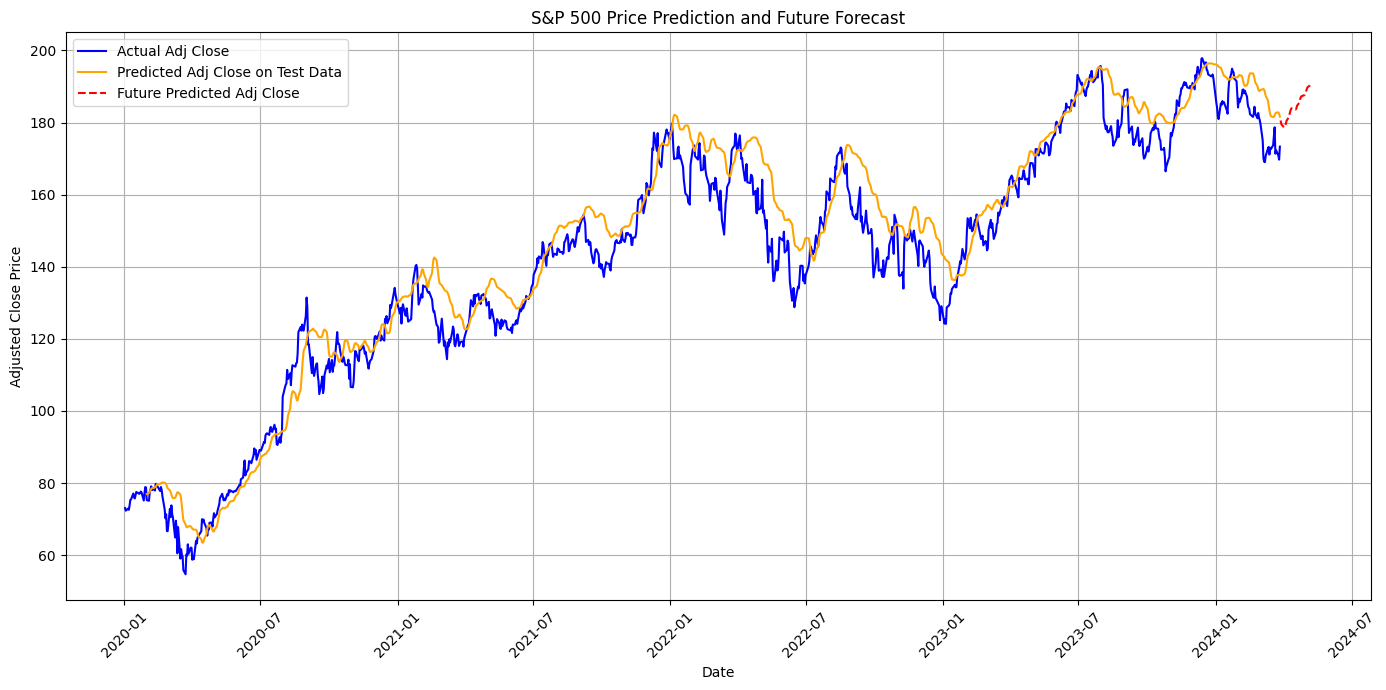

In [ ]:
import matplotlib.pyplot as plt

output_length = len(testingData) - n_steps
output_adjusted = output[:output_length].flatten()
plt.figure(figsize=(14, 7))
plt.plot(testingData.index, testingData['Adj Close'], label='Actual Adj Close', color='blue')
plt.plot(testingData.index[n_steps:], output_adjusted, label='Predicted Adj Close on Test Data', color='orange')
plt.plot(predicted_df.index, predicted_df['Predicted Adj Close'], label='Future Predicted Adj Close', color='red', linestyle='--')
plt.title('S&P 500 Price Prediction and Future Forecast')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()